In [71]:
import numpy as np
import torch 
from torch import nn
from torch.autograd import grad
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [77]:
n = 25
linX = torch.linspace(0, 1, n)
linY = torch.linspace(0, 1, n)

grid_x, grid_y = torch.meshgrid(linX, linY, indexing='ij')

boundary_x = torch.cat((grid_x[0,:], grid_x[-1,:], grid_x[:, 0], grid_x[:, -1]), dim = 0)
boundary_y = torch.cat((grid_y[0,:], grid_y[-1,:], grid_y[:, 0], grid_y[:, -1]), dim = 0)


grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

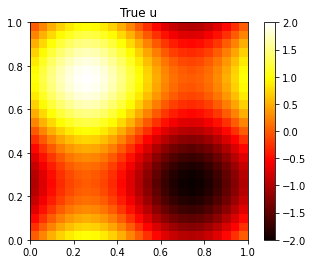

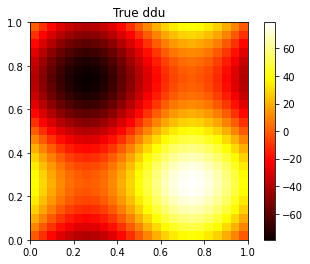

In [78]:
def u_ture(x, y):
    return torch.sin(2*torch.pi*x) + torch.sin(2*torch.pi*y)

def ddu_true(x, y):
    return -4 * (torch.pi ** 2) * (torch.sin(2*torch.pi*x) + torch.sin(2*torch.pi*y))

true_sol = u_ture(grid_x, grid_y).reshape(n,n)
ddtrue_sol = ddu_true(grid_x, grid_y).reshape(n,n)

plt.imshow(true_sol, cmap='hot', interpolation='nearest', extent=[0,1,0,1])
plt.colorbar()
plt.title("True u")
plt.show()

plt.imshow(ddtrue_sol, cmap='hot', interpolation='nearest', extent=[0,1,0,1])
plt.colorbar()
plt.title("True ddu")
plt.show()

In [79]:
from numpy.ma.core import outer
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=3):
        super().__init__()
        
        self.layer_first = nn.Linear(2, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.uout = nn.Linear(nn_width, 1)
        
    def forward(self, x, y):
        if len(x.shape) == 1:
          inpt = torch.cat((x.unsqueeze(1), y.unsqueeze(1)), dim=1)
        else:
          inpt = torch.cat((x, y), dim=1)
        activation = nn.Tanh()
        u = activation(self.layer_first(inpt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))

        out = self.uout(u)

        return out

model = ffnn(64, 4)


In [82]:
def loss_function(model, grid_x, grid_y, boundary_x, boundary_y):

  boundary_out = model(boundary_x, boundary_y).flatten()    
  
  grid_x = torch.tensor(grid_x, requires_grad=True).unsqueeze(1)
  grid_y = torch.tensor(grid_y, requires_grad=True).unsqueeze(1)

  grid_out = model(grid_x, grid_y)
  
  dudx = torch.autograd.grad(grid_out.sum(), grid_x,  create_graph=True, retain_graph=True)[0]
  dudxx = torch.autograd.grad(dudx.sum(), grid_x,  create_graph=True, retain_graph=True)[0]
    
  dudy = torch.autograd.grad(grid_out.sum(), grid_y, create_graph=True, retain_graph=True)[0]
  dudyy = torch.autograd.grad(dudy.sum(), grid_y, create_graph=True, retain_graph=True)[0]
    
  ph_loss = ((dudxx + dudyy + ddu_true(grid_x, grid_y)) ** 2).sum()/dudyy.shape[0]
  b_loss = ((boundary_out + u_ture(boundary_x, boundary_y))** 2).sum()/boundary_out.shape[0]
  
  loss =  ph_loss + b_loss * 1e2
  
  return loss

In [83]:
epochs = 4000
lr = 1e-4
loss_list = []
opt = torch.optim.Adam(model.parameters(), lr)


for i in range(epochs):

    loss = loss_function(model, grid_x, grid_y, boundary_x, boundary_y)
    loss_list.append(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f'epoch {i}, loss = {loss}')
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch 0, loss = 1504.962646484375
epoch 100, loss = 1298.5772705078125
epoch 200, loss = 697.9310913085938
epoch 300, loss = 182.86367797851562
epoch 400, loss = 46.598384857177734
epoch 500, loss = 34.21735382080078
epoch 600, loss = 24.3717041015625
epoch 700, loss = 15.100111961364746
epoch 800, loss = 8.632421493530273
epoch 900, loss = 5.587719917297363
epoch 1000, loss = 3.8411684036254883
epoch 1100, loss = 2.8091018199920654
epoch 1200, loss = 2.1957006454467773
epoch 1300, loss = 1.8074028491973877
epoch 1400, loss = 1.5391452312469482
epoch 1500, loss = 1.3355953693389893
epoch 1600, loss = 1.1810672283172607
epoch 1700, loss = 1.0528254508972168
epoch 1800, loss = 0.950705885887146
epoch 1900, loss = 0.868179976940155
epoch 2000, loss = 0.7993298172950745
epoch 2100, loss = 0.7428706884384155
epoch 2200, loss = 0.6923571228981018
epoch 2300, loss = 0.6492063403129578
epoch 2400, loss = 0.6096176505088806
epoch 2500, loss = 0.5740466117858887
epoch 2600, loss = 0.540550887584

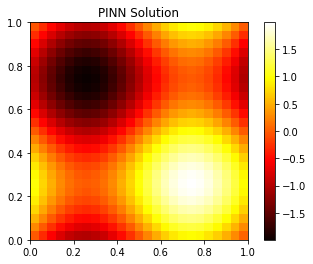

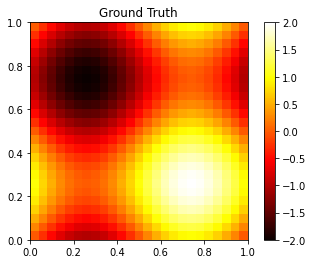

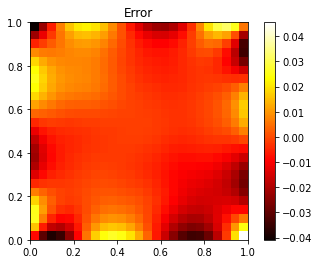

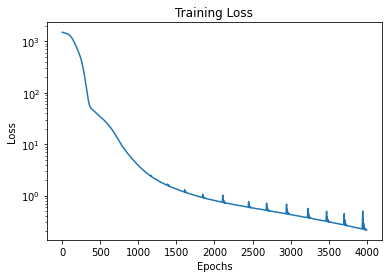

In [84]:
model_out = model(grid_x, grid_y).detach().reshape(n,n)
out = -u_ture(grid_x, grid_y).reshape(n,n)
plt.imshow(model_out, cmap='hot', interpolation='nearest', extent=[0,1,0,1])
plt.title('PINN Solution')
plt.colorbar()
plt.show()

plt.imshow(out, cmap='hot', interpolation='nearest', extent=[0,1,0,1])
plt.title('Ground Truth')
plt.colorbar()
plt.show()

plt.imshow(model_out-out, cmap='hot', interpolation='nearest', extent=[0,1,0,1])
plt.title('Error')
plt.colorbar()
plt.show()

plt.figure()
plt.plot(loss_list)
plt.ylabel('Loss')
plt.yscale('log')
plt.xlabel('Epochs')
plt.title('Training Loss')
plt.show()